In [413]:
import pandas as pd
import matplotlib.pyplot
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [414]:
# Retrives resuable funcitons and load the data and create the subset of the data needed
%run mlLibrary.ipynb
%run BasicDataExploration.ipynb

# Load the dataset
df_revision_4 = pd.read_csv('DataSampled.csv')
df_revision_4.head(2)

,MMSE,Age,Weight,Height,Waist,Hip,Smoking,Smoking (packet/year),Alcohol,DM,DM duration,İnsülin,DM drug,Hiperlipidemi,Dyslipidemia duration,Dyslipidemia drugs,KAH,KAH duration,Hipotiroidi,ASTIM,KOAH,OP,Other(s),HT,Anti-HT drug type,HT duration,Education,Occupation,Working Status,Exercise,LowCST,CST,Gait speed,Low grip strength,Grip strength,SARCOPENIA,STAR,BMI,Gender
0,NaN,64,66.0,155.0,89.0,104.0,0.0,0,0,0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,0.0,High School,Officer,Retire,0,0.0,8.1,1.28,0.0,28.0,0.0,1.00,27.4,F
1,NaN,53,55.0,150.0,77.0,97.0,0.0,0,0,0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,aritmi,0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,8.0,1.47,1.0,16.0,0.0,1.84,24.4,F


In [415]:
# Create the dataframes to show the data
# Create the dataframes to show the data
model_3_logistic_male = getResultsDataFrame("h_model_3_logistic_male")
model_3_forest_male   = getResultsDataFrame("h_model_3_forest_male")
model_3_gradient_male = getResultsDataFrame("h_model_3_gradient_male")

model_3_logistic_female = getResultsDataFrame("h_model_3_logistic_female")
model_3_forest_female = getResultsDataFrame("h_model_3_forest_female")
model_3_gradient_female = getResultsDataFrame("h_model_3_gradient_female")

In [416]:
# Create the male/female models
column_list = ['Gender', 'Grip strength', 'SARCOPENIA']

# Create the exact dataframe needed and add the index column to merge the data frame created in the model with the data from the previous model
(df_female, df_male) = createDataframesForModel(df_revision_4, column_list)

# For the model created reset the index so the number are sequential (ex. 1,2,3,4,5) not (1, 3, 4, ,6) and make it a column
df_female = df_female.reset_index()
df_male = df_male.reset_index()
df_female["index"] = df_female.index
df_male["index"] = df_male.index
print("Shape of female", df_female.shape, "Shape of male", df_male.shape)


Shape of female (924, 4) Shape of male (379, 4)


Exploration of the Numeric Data

Plot the Historgram of the Numerical Data to decide to use either normalization or standardization 
> * StadardScalar will used for Gait and Gait Speed since they closely resemble Gaussian 

Plot the boxplot to get a look at the ouliers
> * Male CST seems to have a lot of outliers .  These could be points that are hard to classify since they may invade another targets category.
> > * The first step will be to remove them.
> * The numeric plots show ranges that are not logarithmic

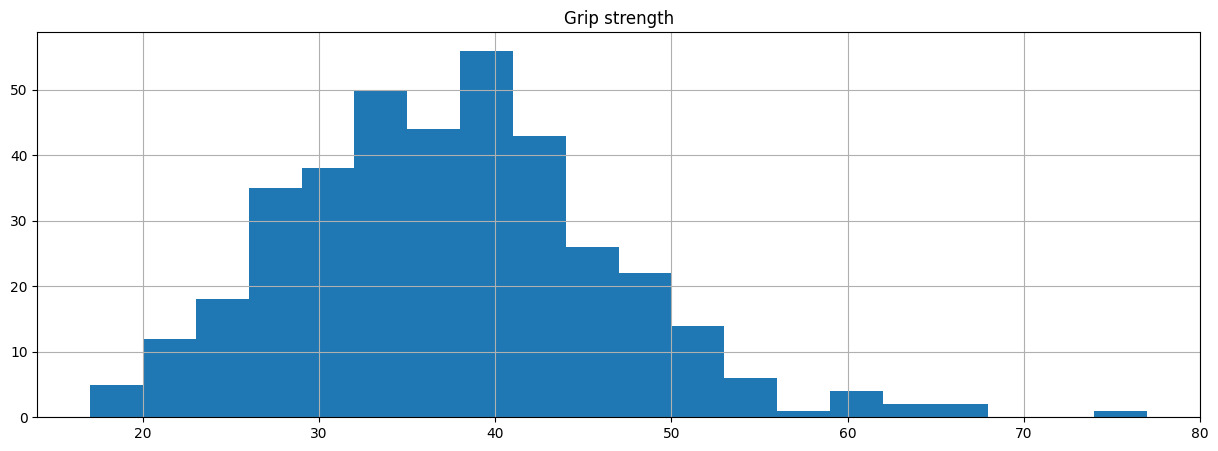

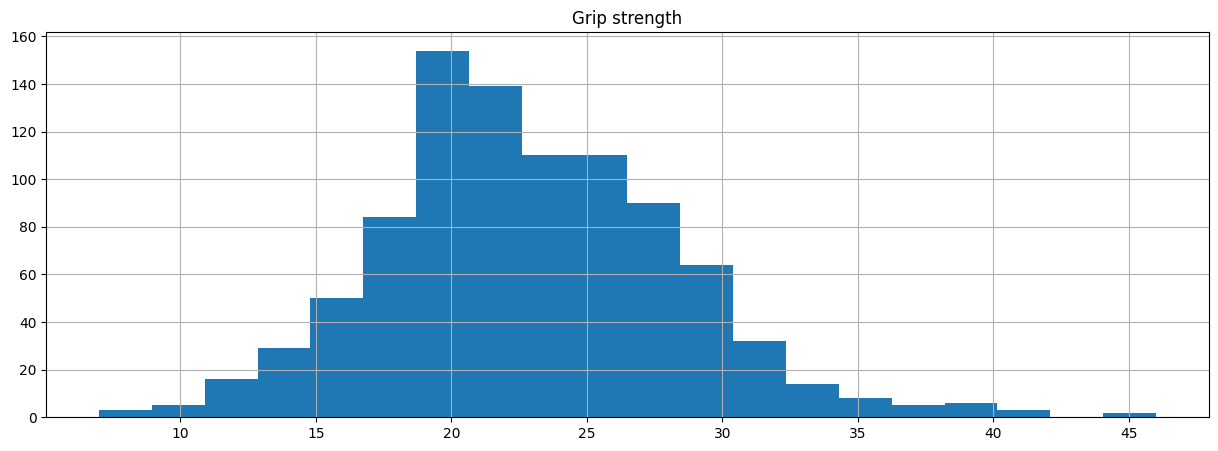

In [417]:
# Look at the histograms of the Age, Weight and Height
(figure, ravel_ax) = createGraph(1,1)
(figure, ravel_ax1) = createGraph(1,1)

columns_to_plot = ['Grip strength']
for index, column in enumerate(columns_to_plot):
    df_male.hist(column=column, bins=20, ax=ravel_ax[index])
    df_female.hist(column=column, bins=20, ax=ravel_ax1[index])



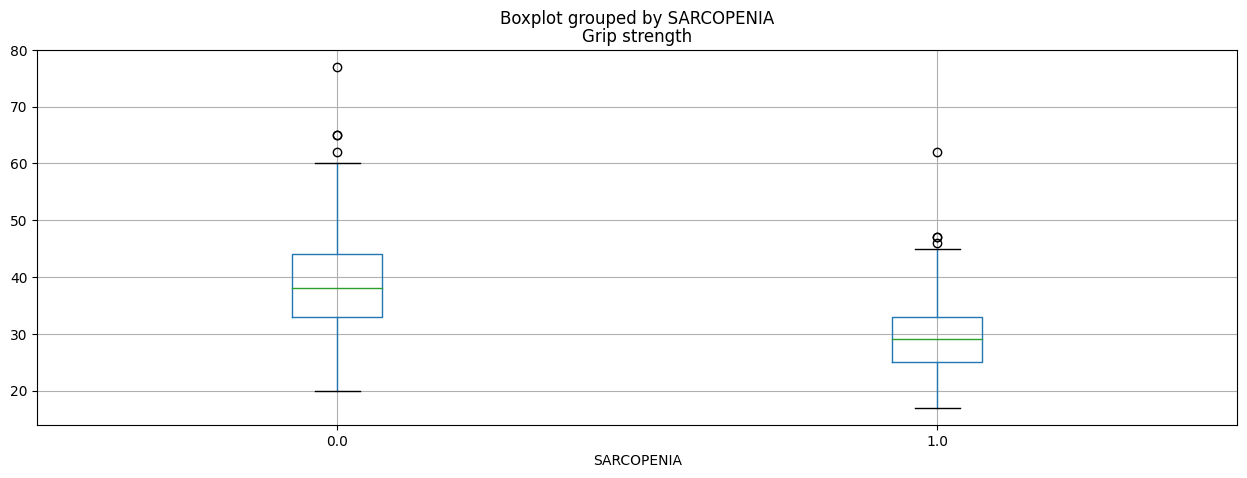

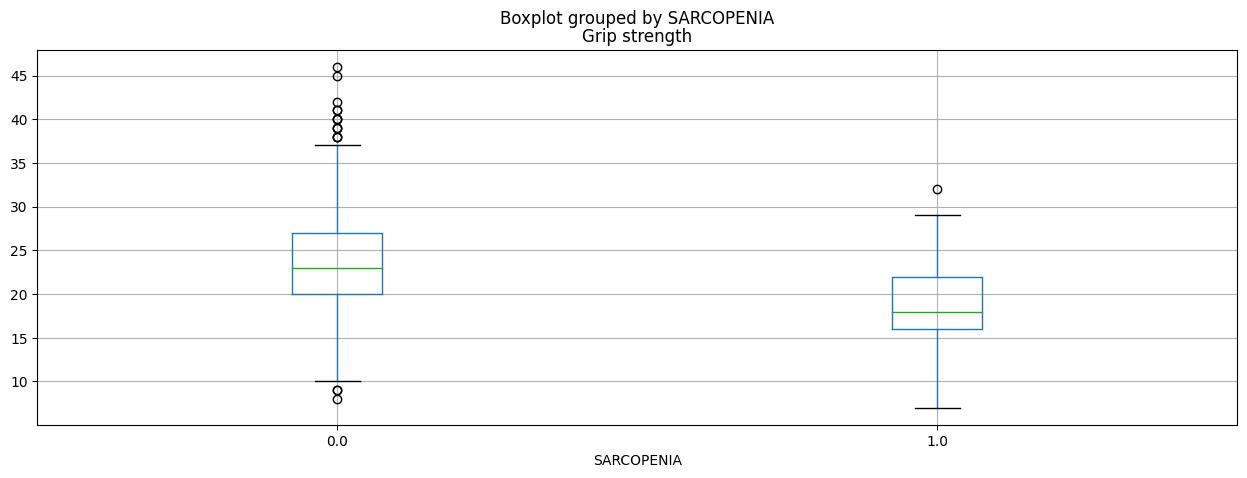

In [418]:
# Look at the Box plot to get a sense of the ourliers and should Log

(figure, ravel_ax) = createGraph(1,1)
(figure, ravel_ax1) = createGraph(1,1)

columns_to_plot = ['Grip strength']
for index, column in enumerate(columns_to_plot):
    df_male.boxplot(column=column,   by='SARCOPENIA', ax=ravel_ax[index])
    df_female.boxplot(column=column, by='SARCOPENIA', ax=ravel_ax1[index])

In [419]:
## Data Clean -- None is needed since we have one numeric field.

In [420]:
column_data = info_about_columns(dataframe=df_male, data_science_descriptions=None)
column_data

,DataType,# of Categories,categories/sample ratio,missing values,missing values %
index,int64,379,100.0,0,0.000000
Gender,object,1,0.0,0,0.000000
Grip strength,float64,44,12.0,0,0.000000
SARCOPENIA,float64,2,1.0,1,0.263852


In [421]:
show_examples_of_data(dataframe=df_male, data_information=column_data, category_cutoff=3)

,Field,Value,Number of Values
0,index,0 to 378,NA
1,Gender,[m],1
2,Grip strength,17.0 to 77.0,NA
3,SARCOPENIA,"[0.0, 1.0, nan]",3


In [422]:
column_data = info_about_columns(dataframe=df_female, data_science_descriptions=None)
column_data

,DataType,# of Categories,categories/sample ratio,missing values,missing values %
index,int64,924,100.0,0,0.0
Gender,object,1,0.0,0,0.0
Grip strength,float64,38,4.0,0,0.0
SARCOPENIA,float64,2,0.0,0,0.0


In [423]:
show_examples_of_data(dataframe=df_female, data_information=column_data, category_cutoff=5)

,Field,Value,Number of Values
0,index,0 to 923,NA
1,Gender,[f],1
2,Grip strength,7.0 to 46.0,NA
3,SARCOPENIA,"[0.0, 1.0]",2


# Coorelation 
Since I am new to Data Science I want a high correlation to remove a feature ( Correlation of .9 or greater)

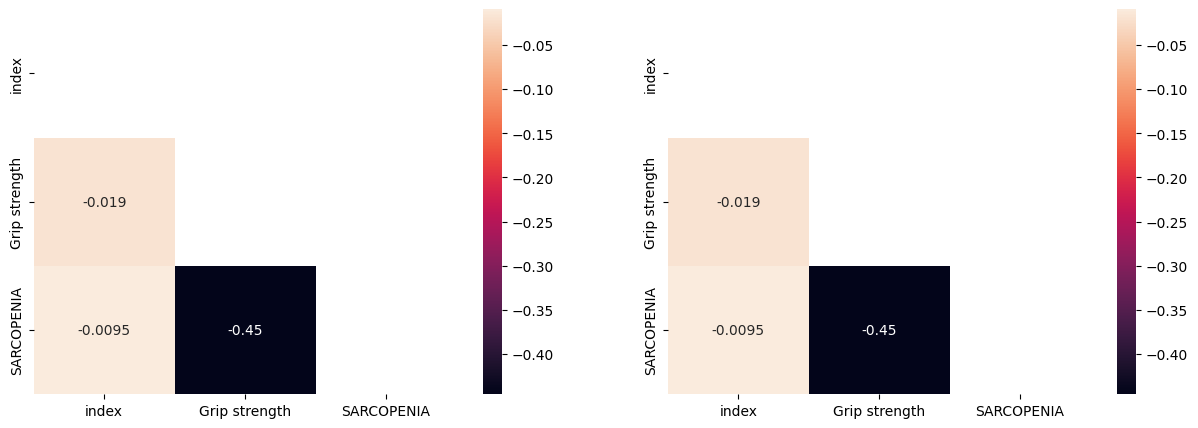

In [424]:
(fiure, ax) = createGraph(1,2)

createHeatMap(df_male,0)
createHeatMap(df_female,1)

In [425]:
# ## Save the data so another model can use it 

## Merge the Data Sets with the column gender

In [426]:
#
# Merge the dataframe from model 1 with the new data from model 2 using Gender Column to do the inner join0
# Before the merge delete the column 'SACROPENIA' since we do not need the same column twice
# After the merge delete the Gender column from the dataframe created in model 2 since it was only for the inner join

model_2_female = pd.read_csv('model_2_female.csv')
model_2_male = pd.read_csv('model_2_male.csv')

model_2_female["index"] = model_2_female.index
model_2_male["index"] = model_2_male.index

model_3_female = model_2_female.merge(df_female, how='inner', on="index")
model_3_male = model_2_male.merge(df_male, how='inner', on='index')

model_3_female

model_3_male = model_3_male.drop(['Unnamed: 0', 'Gender', 'Unnamed: 0', 'SARCOPENIA_x'], axis=1)
model_3_male = model_3_male.rename(columns={'SARCOPENIA_y':'SARCOPENIA'})

model_3_female = model_3_female.drop(['Unnamed: 0', 'Gender', 'Unnamed: 0', 'SARCOPENIA_x' ], axis=1)
model_3_female = model_3_female.rename(columns={'SARCOPENIA_y':'SARCOPENIA'})

print("Size of the male model", model_2_male.shape)
print("Size of the female model", model_2_female.shape)

Size of the male model (379, 13)
Size of the female model (924, 13)


In [427]:
model_3_female.head(10)

,Age,Weight,Height,Exercise,HT,DM,Education,Smoking,index,CST,Gait speed,Grip strength,SARCOPENIA
0,64,66.0,155.0,0,0,0,high_school,0,0,8.1,1.28,28.0,0.0
1,53,55.0,150.0,NaN,0,0,NaN,0,1,8.0,1.47,16.0,0.0
2,56,56.0,150.0,0,1,0,illiterate,0,2,11.7,0.80,23.0,0.0
3,58,75.0,160.0,0,1,1,illiterate,1,3,18.0,1.34,23.0,0.0
4,55,72.0,157.0,1-2/week,0,0,elementry,0,4,10.9,1.09,21.0,0.0
5,60,65.0,164.0,0,0,0,high_school,0,5,9.2,1.13,22.0,0.0
6,75,74.0,170.0,1-2/week,1,0,illiterate,0,6,10.1,1.36,22.0,0.0
7,60,80.0,150.0,0,1,0,illiterate,0,7,26.3,2.06,19.0,0.0
8,53,62.0,155.0,0,0,0,high_school,0,8,10.2,1.30,27.0,0.0
9,68,70.0,160.0,3-4/week,1,0,primary school,0,9,9.5,1.46,26.0,0.0


### Remove any rows where any column has no data
I would have put this into a column transformer, but an Imputer will not remove rows and of the guiding idas was to create a model quickly and optimize at later time.

In [428]:
original_size_male = model_2_male.shape
model_3_male = model_3_male.dropna(axis=0)
new_size_male = model_3_male.shape
print("Male Original/New", original_size_male, new_size_male)

Male Original/New (379, 13) (373, 13)


In [429]:
original_size_female = model_2_female.shape
model_3_female = model_3_female.dropna(axis=0)
new_size_female = model_3_female.shape
print("Female Original/New", original_size_female, new_size_female)

Female Original/New (924, 13) (905, 13)


In [430]:
## Create Training Set and graph the balance/inbalance of the dataset

In [431]:
# Create the Training and Datasets
(XTrain_female, XTest_female, yTrain_female, yTest_female) = createTestTrainData(dataframe=model_3_female, test_size=.25)
(XTrain_male,   XTest_male,   yTrain_male,   yTest_male)   = createTestTrainData(dataframe=model_3_male, test_size=.25)


In [432]:
## Analyzing the Balancing/Inbalancing

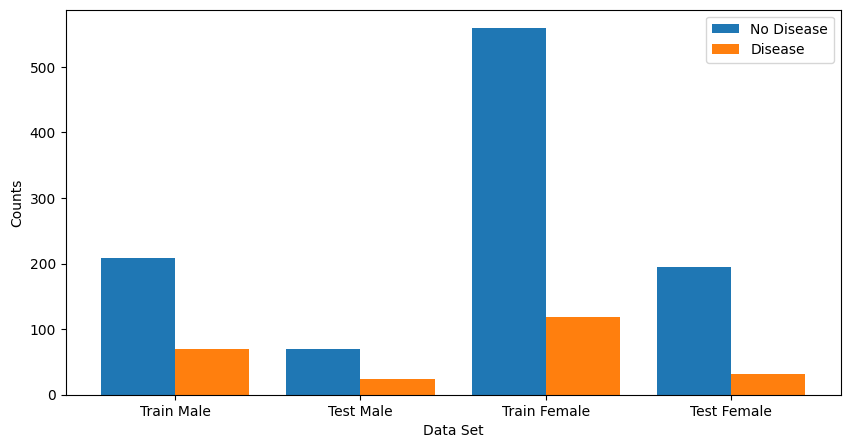

In [433]:
# Show the counts for the disease 
columns = ["Traing Male", "Test Male", "Train Female", "Test Female"]
showBalanceOfDataset(columns, yTrain_male, yTest_male, yTrain_female, yTest_female) 

## Analysis of creating the Training/Testing for the Dataset.

The dataset is out of whack.  It is definietly unbalanced.   However, I have decided to move on and take this into account later.
Usually I would remove data, but in this case, I may want to create new data since the counts of the disease is so null.  However,
this was mentioned in class

### Create the Column Transofrmers -- I wanted to put all the preproccessing here, but could not delete rows in a column transformer

In [434]:
# column_transforms_list = [
#     ("encoding", OneHotEncoder(), ["Exercise","HT","DM", "Education", "Smoking"])
# ]
    
columnTransformer = ColumnTransformer([
    ('normalization', MinMaxScaler(), ["Age"]),
    ('standard scalar', StandardScaler(), [ "Height", "Weight" ]),
    ('ohe_exercise', OneHotEncoder(handle_unknown='ignore'), [ "HT", "Education", "DM", "Smoking", "Exercise"])
],remainder='passthrough')


In [435]:
# Lets take a look at LogisticRegresson

# The first test must select the solver since the the penalty hyperparameter must have the correct vslues for the 
# solver hyperparameter.  If the solver is invalid for the penalty then an error error generated and the training
# and test sets would return NaN instead of percentage correct.  Optimize for this parameter first then the others.
# Two parameter dictionaries will need so that we can evaluate each solver without any issues.

parameters1 = {
      "logisticRegression__solver": [ 'newton-cholesky', 'newton-cg', 'liblinear', 'sag', 'saga'] 
}

parameters2 = {
     "logisticRegression__solver": [ 'lbfgs' ]
}

parameters3 = {
    'logisticRegression__penalty': [ 'l2', None],
    'logisticRegression__C': [ 100, 10, 1, 0.1, .01, .001 ],
    'logisticRegression__class_weight' : [ None, 'balanced']
}

# Make the PipeLine 
pipeline = Pipeline(
     [
         ( "Column Transformers", columnTransformer),
         ( "logisticRegression", LogisticRegression(max_iter=8000, solver="lbfgs"))
     ])

grid_male_list = []
grid_female_list = []
y_predictions_male_list = []
y_predictions_female_list = []

experiments = [ parameters1, parameters2, parameters3 ]
for experiment in experiments:
    (grid, y_predictions_male) = trainTestScore(pipeline, experiment, 10, (XTrain_male, yTrain_male), (XTest_male, yTest_male))
    (grid2, y_predictions_female) = trainTestScore(pipeline, experiment, 10, (XTrain_female, yTrain_female), (XTest_female, yTest_female))

    grid_male_list.append(grid)
    grid_female_list.append(grid2)
    y_predictions_male_list.append(y_predictions_male)
    y_predictions_female_list.append(y_predictions_female)


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.861, test=0.750) total time=   0.0s
[CV 2/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.849, test=0.750) total time=   0.0s
[CV 3/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.869, test=0.821) total time=   0.0s
[CV 4/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.865, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.857, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.849, test=0.821) total time=   0.0s
[CV 7/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.857, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.861, test=0.821) total time=   0.0s
[CV 9/10] END logisticRegression__solver=newton-cholesky;, 

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END logisticRegression__solver=saga;, score=(train=0.853, test=0.786) total time=   0.2s
[CV 2/10] END logisticRegression__solver=saga;, score=(train=0.853, test=0.786) total time=   0.2s
[CV 3/10] END logisticRegression__solver=saga;, score=(train=0.857, test=0.857) total time=   0.2s
[CV 4/10] END logisticRegression__solver=saga;, score=(train=0.837, test=0.893) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END logisticRegression__solver=saga;, score=(train=0.853, test=0.786) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END logisticRegression__solver=saga;, score=(train=0.849, test=0.857) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END logisticRegression__solver=saga;, score=(train=0.841, test=0.893) total time=   0.2s
[CV 8/10] END logisticRegression__solver=saga;, score=(train=0.841, test=0.821) total time=   0.2s
[CV 9/10] END logisticRegression__solver=saga;, score=(train=0.845, test=0.857) total time=   0.2s
[CV 10/10] END logisticRegression__solver=saga;, score=(train=0.845, test=0.889) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(94, 12)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.848, test=0.809) total time=   0.0s
[CV 2/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.848, test=0.882) total time=   0.0s
[CV 3/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.841, test=0.897) total time=   0.0s
[CV 4/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.848, test=0.853) total time=   0.0s
[CV 5/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.862, test=0.779) total time=   0.0s
[CV 6/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.844, test=0.853) total time=   0.0s
[CV 7/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.854, test=0.853) total time=   0.0s
[CV 8/10] END logisticRegression__solver=newton-cholesky;, score=(train=0.852, test=0.853) total time=   0.0s
[CV 9/10] END logisticRegression__solver=newton-ch

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 1/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.750) total time=   0.0s
[CV 2/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.750) total time=   0.0s
[CV 3/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.786) total time=   0.0s
[CV 4/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.786) total time=   0.0s
[CV 

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.809, test=0.786) total time=   0.0s
[CV 3/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.801, test=0.750) total time=   0.0s
[CV 4/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.813, test=0.821) total time=   0.0s
[CV 5/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.797, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.789, test=0.857) total time=   0.0s
[CV 7/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.793, test=0.821) total time=

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 4/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.813, test=0.821) total time=   0.0s
[CV 5/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.857) total time=   0.0s
[CV 7/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.793, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.817, test=0.750) total time=   0.0s
[CV 9/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.893)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 10/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.833, test=0.519) total time=   0.0s
[CV 1/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.861, test=0.750) total time=   0.1s
[CV 2/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.853, test=0.750) total time=   0.0s
[CV 3/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.853, test=0.786) total time=   0.1s
[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.861, test=0.893) total time=   0.1s
[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 6/10] END 

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.786) total time=   0.0s
[CV 7/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 9/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.853, test=0.821) total time=   0.0s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 10/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.815) total time=   0.0s
[CV 1/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.813, test=0.750) total time=   0.1s
[CV 2/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.817, test=0.786) total time=   0.1s
[CV 3/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.797, test=0.750) total time=   0.1s
[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.813, test=0.821) total time=   0.1s
[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.801, test=0.786) total time=   0.0s

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 6/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.857) total time=   0.0s
[CV 7/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.793, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.817, test=0.750) total time=   0.0s
[CV 9/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.893) total time=   0.0s
[CV 10/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.833, test=0.519) total time=   0.0s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.861, test=0.750) total time=   0.0s
[CV 2/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.849, test=0.750) total time=   0.0s
[CV 3/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.869, test=0.821) total time=   0.0s
[CV 4/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.861, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.857, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.853, test=0.821) total time=   0.0s
[CV 7/10] END logisticRegres

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 6/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.786) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 9/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.853, test=0.821) total time=   0.0s
[CV 10/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.815) total time=   0.0s
[CV 1/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.809, test=0.750) total time=   0.0s
[

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.797, test=0.821) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.809, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.813, test=0.750) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.801, test=0.821) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.793, test=0.786) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.809, test=0.786) total time=

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 3/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.801, test=0.750) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.813, test=0.821) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.857) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.793, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.817, test=0.750)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.893) total time=   0.0s
[CV 10/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.833, test=0.519) total time=   0.0s
[CV 1/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.813, test=0.786) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.825, test=0.679) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.805, test=0.821) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.817, test=0.857) total time=   0.0s

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.750) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.786) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.786) total time=   0.0s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 9/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.853, test=0.821) total time=   0.0s
[CV 10/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.815) total time=   0.0s
[CV 1/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.825, test=0.750) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.809, test=0.714) total time= 

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 5/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.857) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.793, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.817, test=0.750) total time=   0.0s
[CV 9/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.893) total time=   0.0s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 10/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.833, test=0.519) total time=   0.0s
[CV 1/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.805, test=0.821) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.801, test=0.750) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.801, test=0.786) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.793, test=0.857) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.777, test=0.786) total time=   0.0

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.786) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.893) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.786) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.821) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.861, test=0.786) total time=

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.853, test=0.821) total time=   0.0s
[CV 10/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.845, test=0.815) total time=   0.0s
[CV 1/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.789, test=0.679) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.793, test=0.714) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.785, test=0.714) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.773, test=0.857) to

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.809, test=0.821) total time=   0.1s
[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.801, test=0.750) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.813, test=0.821) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.786) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.857) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.793,

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 8/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.817, test=0.750) total time=   0.0s
[CV 9/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.893) total time=   0.0s
[CV 10/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.833, test=0.519) total time=   0.0s
(94, 12)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.856, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.848, test=0.882) total time=   0.1s
[CV 3/10] END logisticRegression__C=100, logisticRegression__class_weight=None, log

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.844, test=0.897) total time=   0.1s
[CV 4/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.856, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.864, test=0.750) total time=   0.1s
[CV 6/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.852, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.838) total time=   0.1s
[CV 8/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.846, test=0.866) total time=   0.1s
[CV 10/10] END logisticRegression__C=100, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.797, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.784, test=0.853) total time=   0.1s
[CV 3/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.798, test=0.824) total time=   0.1s
[CV 4/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.790, test=0.882) total time=   

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.790, test=0.853) total time=   0.1s
[CV 3/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.798, test=0.809) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.882) total time=   0.2s
[CV 5/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.721) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 6/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.824) total time=   0.1s
[CV 7/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.691) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 8/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.795, test=0.838) total time=   0.2s
[CV 9/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.761) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 10/10] END logisticRegression__C=100, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.761) total time=   0.2s
[CV 1/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.854, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.849, test=0.882) total time=   0.1s
[CV 3/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.843, test=0.897) total time=   0.1s
[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.852, test=0.853) total time=   0.1s
[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.866, test=0.765) total time=   0.1s
[CV 6/10] END 

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.848, test=0.882) total time=   0.2s
[CV 3/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.844, test=0.897) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.856, test=0.853) total time=   0.1s
[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.864, test=0.750) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 6/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.852, test=0.853) total time=   0.1s
[CV 7/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.838) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 8/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.853) total time=   0.1s
[CV 9/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.846, test=0.866) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 10/10] END logisticRegression__C=10, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.797, test=0.824) total time=   0.1s
[CV 2/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.785, test=0.838) total time=   0.1s
[CV 3/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.793, test=0.794) total time=   0.0s
[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.787, test=0.882) total time=   0.1s
[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.808, test=0.706) total time=   0.1s

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.794) total time=   0.2s
[CV 2/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.790, test=0.853) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.798, test=0.809) total time=   0.2s
[CV 4/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.882) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.721) total time=   0.2s
[CV 6/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.824) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.691) total time=   0.1s
[CV 8/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.795, test=0.838) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.761) total time=   0.2s
[CV 10/10] END logisticRegression__C=10, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.761) total time=   0.2s
[CV 1/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.848, test=0.809) total time=   0.0s
[CV 2/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.846, test=0.882) total time=   0.1s
[CV 3/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.841, test=0.897) total time=   0.1s
[CV 4/10] END logisticRegression__C=1, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.846, test=0.853) total time=   0.0s
[CV 5/10] END

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.848, test=0.882) total time=   0.1s
[CV 3/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.844, test=0.897) total time=   0.1s
[CV 4/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.856, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.864, test=0.750) total time=   0.2s
[CV 6/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.852, test=0.853) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.838) total time=   0.2s
[CV 8/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.846, test=0.866) total time=   0.1s
[CV 10/10] END logisticRegression__C=0.1, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.795, test=0.809) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.787, test=0.838) total time=   0.0s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.800, test=0.794) total time=   0.1s
[CV 4/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.782, test=0.868) total time=   0.0s
[CV 5/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.795, test=0.735) total time=   0.0s
[CV 6/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.785, test=0.809) total time=   0.0s
[CV 7/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.807, test=0.662) total time=   0.0s
[CV 8/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.792, test=0.809) total time=

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.790, test=0.853) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.798, test=0.809) total time=   0.2s
[CV 4/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.882) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.721) total time=   0.1s
[CV 6/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.824) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.691) total time=   0.2s
[CV 8/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.795, test=0.838) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.761) total time=   0.2s
[CV 10/10] END logisticRegression__C=0.1, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.838, test=0.794) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.833, test=0.838) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.830, test=0.853) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.831, test=0.838) total time=   0.0s

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.849, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.848, test=0.882) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.844, test=0.897) total time=   0.1s
[CV 4/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.856, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.864, test=0.750) total time=   0.2s
[CV 6/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.852, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.838) total time=   0.1s
[CV 8/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.846, test=0.866) total time=   0.1s
[CV 10/10] END logisticRegression__C=0.01, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.803, test=0.809) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.793, test=0.868) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.798, test=0.794) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.797, test=0.853) total ti

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.790, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.798, test=0.809) total time=   0.2s
[CV 4/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.882) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.721) total time=   0.1s
[CV 6/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.824) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.691) total time=   0.2s
[CV 8/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.795, test=0.838) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.761) total time=   0.1s
[CV 10/10] END logisticRegression__C=0.01, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.826, test=0.809) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.826, test=0.824) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.830, test=0.838) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=l2;, score=(train=0.830, test=0.824) total time= 

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.848, test=0.882) total time=   0.1s
[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.844, test=0.897) total time=   0.1s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.856, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.864, test=0.750) total time=   0.1s
[CV 6/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.852, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.857, test=0.838) total time=   0.1s
[CV 8/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.846, test=0.866) total time=   0.1s
[CV 10/10] END logisticRegression__C=0.001, logisticRegression__class_weight=None, logisticRegression__penalty=None;, score=(train=0.851, test=0.761) total time=   0.1s
[CV 1/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.787, test=0.809) total time=   0.0s
[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.780, test=0.853) total time=   0.0s
[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.782, test=0.794) total time=   0.0s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=l2;, score=(train=0.779, test=0.809) to

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.794) total time=   0.1s
[CV 2/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.790, test=0.853) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.798, test=0.809) total time=   0.2s
[CV 4/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.789, test=0.882) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.721) total time=   0.1s
[CV 6/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.824) total time=   0.2s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 7/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.808, test=0.691) total time=   0.2s
[CV 8/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.795, test=0.838) total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 9/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.797, test=0.761) total time=   0.2s
[CV 10/10] END logisticRegression__C=0.001, logisticRegression__class_weight=balanced, logisticRegression__penalty=None;, score=(train=0.805, test=0.761) total time=   0.1s
(227, 12)


Analysis of Males for experiment 0
The Training Score is  0.86
The Test     Score is  0.82
Accuracy     Score is  0.84
Precision    Score is  0.85
Recall       Score is  0.46
best               is  {'logisticRegression__solver': 'saga'}


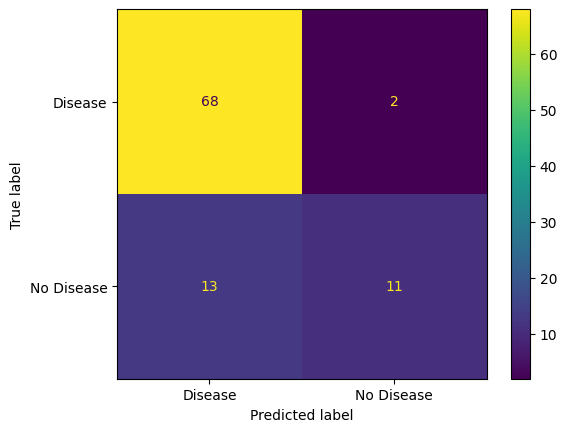

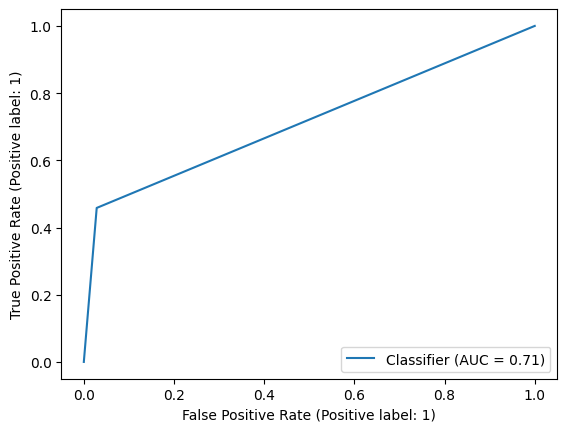

Analysis of Females for experiment 0
The Training Score is  0.85
The Test     Score is  0.84
Accuracy     Score is  0.86
Precision    Score is  0.5
Recall       Score is  0.22
best               is  {'logisticRegression__solver': 'newton-cholesky'}


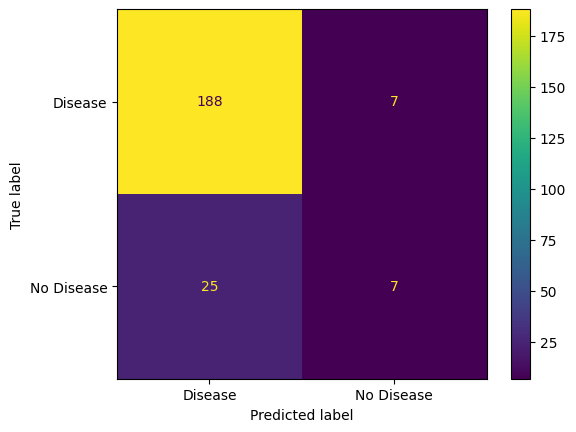

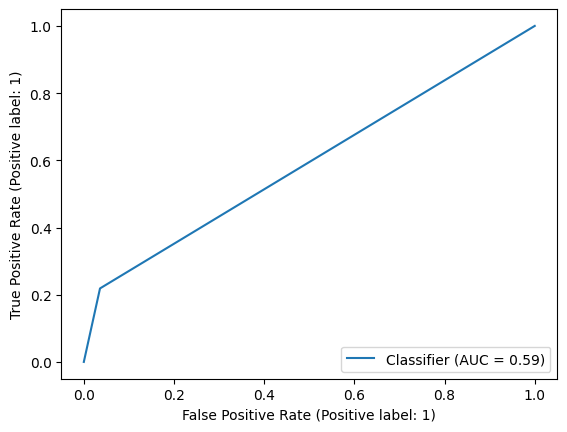

Analysis of Males for experiment 1
The Training Score is  0.86
The Test     Score is  0.82
Accuracy     Score is  0.79
Precision    Score is  0.67
Recall       Score is  0.33
best               is  {'logisticRegression__solver': 'lbfgs'}


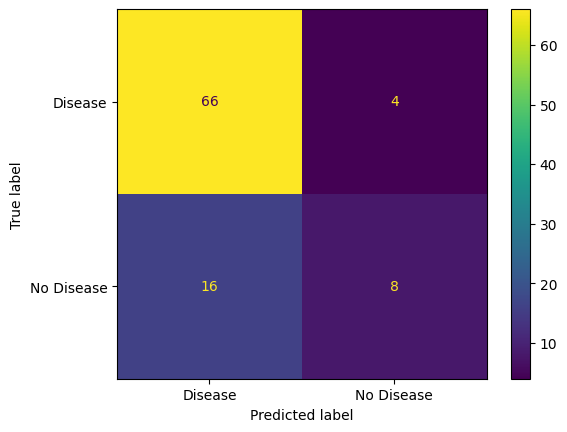

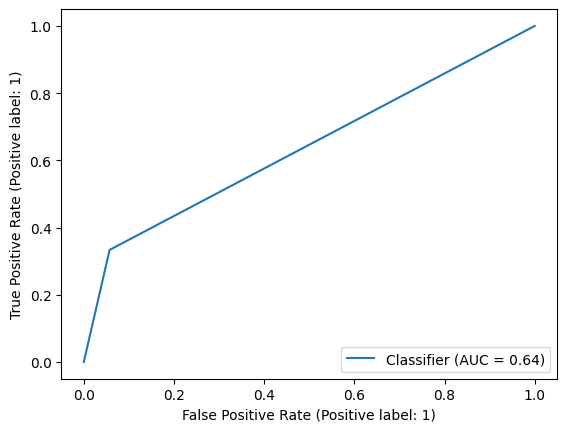

Analysis of Females for experiment 1
The Training Score is  0.85
The Test     Score is  0.84
Accuracy     Score is  0.86
Precision    Score is  0.5
Recall       Score is  0.22
best               is  {'logisticRegression__solver': 'lbfgs'}


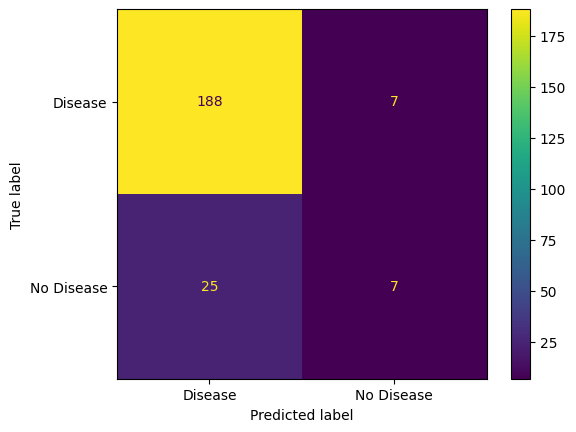

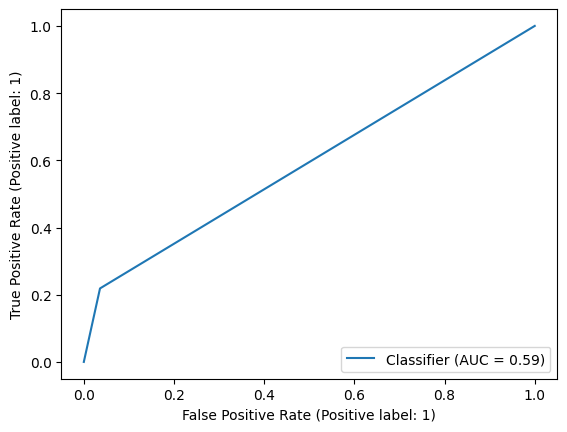

Analysis of Males for experiment 2
The Training Score is  0.86
The Test     Score is  0.8
Accuracy     Score is  0.79
Precision    Score is  0.67
Recall       Score is  0.33
best               is  {'logisticRegression__C': 1, 'logisticRegression__class_weight': None, 'logisticRegression__penalty': 'l2'}


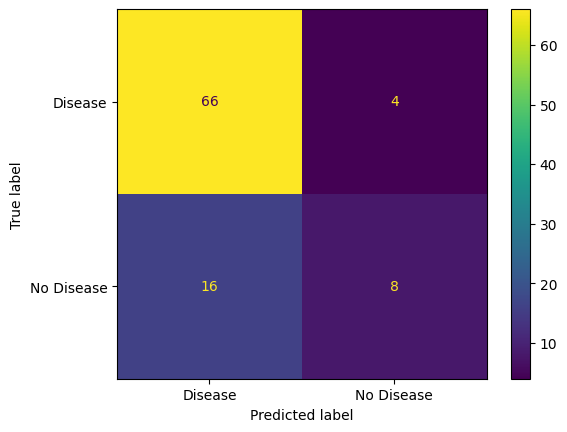

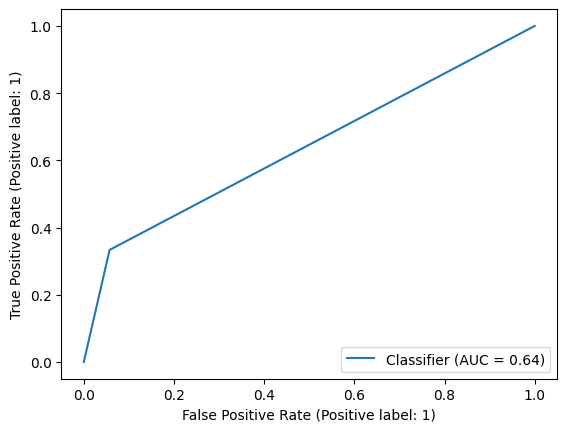

Analysis of Females for experiment 2
The Training Score is  0.85
The Test     Score is  0.83
Accuracy     Score is  0.86
Precision    Score is  0.5
Recall       Score is  0.22
best               is  {'logisticRegression__C': 10, 'logisticRegression__class_weight': None, 'logisticRegression__penalty': 'l2'}


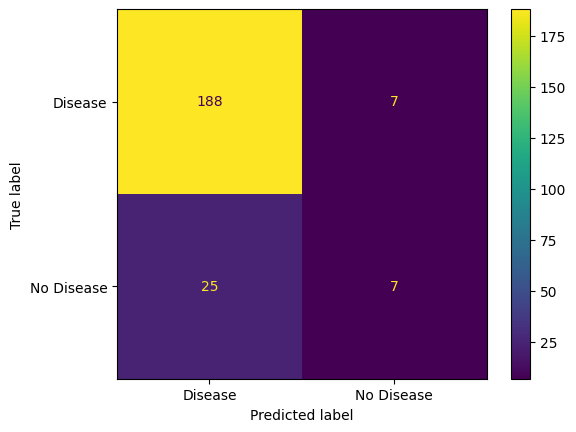

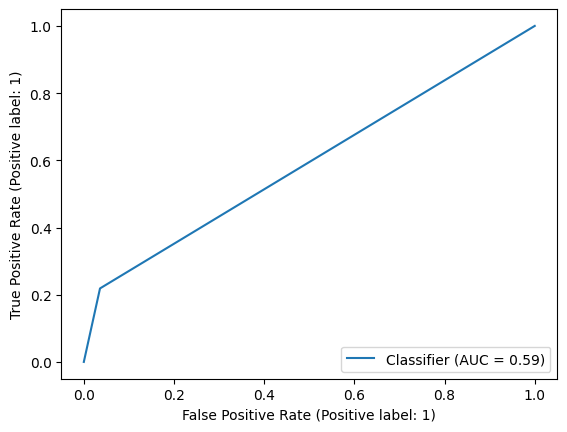

In [436]:
for index in range(0,len(experiments)):
    print("Analysis of Males for experiment", index)
    results(grid_male_list[index], 'logisticRegression', XTest_male, yTest_male, y_predictions_male_list[index], model_3_logistic_male, "h_model_3_logistic_male")

    print("Analysis of Females for experiment", index)    
    results(grid_female_list[index], 'logisticRegression', XTest_female, yTest_female, y_predictions_female_list[index], model_3_logistic_female, "h_model_3_logistic_female")

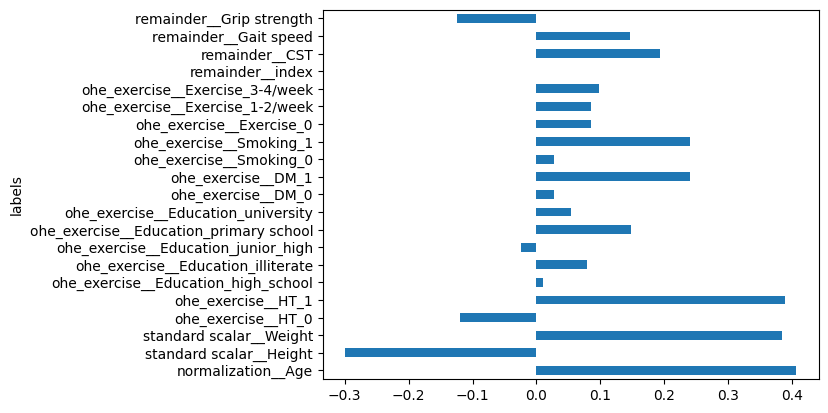

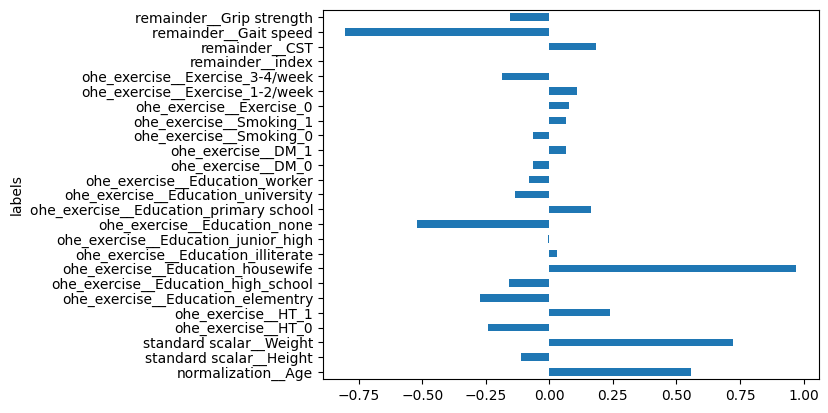

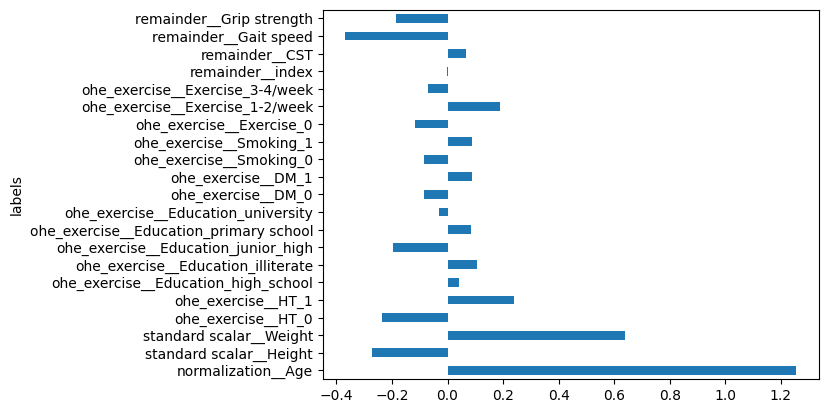

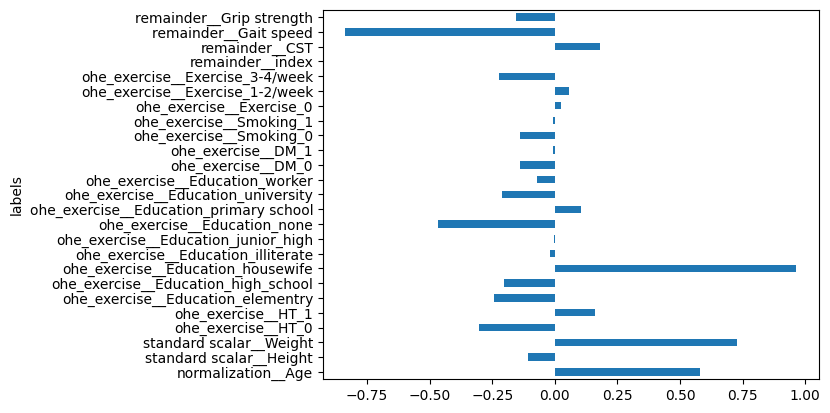

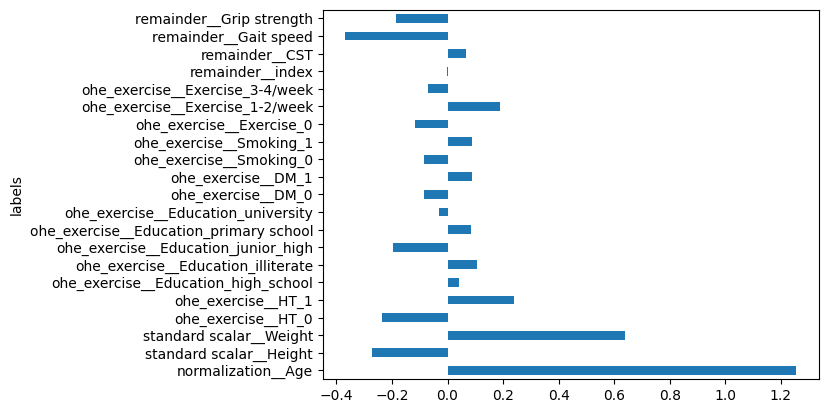

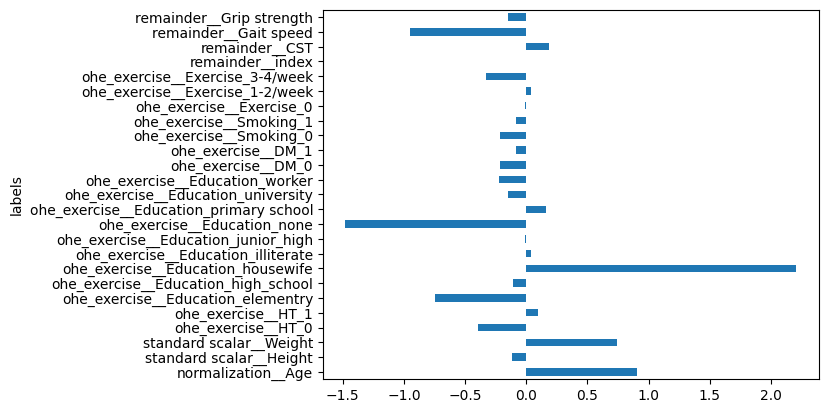

In [437]:
for index in range(0,len(experiments)):
    feature(grid_male_list[index])
    feature(grid_female_list[index])

In [438]:
print("Historical results for male")
getDataFrame("h_model_3_logistic_male")

Historical results for male


,Best Parameters,Training Score,Testing Score,Accuracy,Precision,Recall
0,{'logisticRegression__solver': 'saga'},0.86,0.82,0.84,0.85,0.46
1,{'logisticRegression__solver': 'lbfgs'},0.86,0.82,0.79,0.67,0.33
2,"{'logisticRegression__C': 1, 'logisticRegression__class_weight': None, 'logisticRegression__penalty': 'l2'}",0.86,0.80,0.79,0.67,0.33


In [439]:
print("Historical results for female")
getDataFrame("h_model_3_logistic_female")

Historical results for female


,Best Parameters,Training Score,Testing Score,Accuracy,Precision,Recall
0,{'logisticRegression__solver': 'newton-cholesky'},0.85,0.84,0.86,0.5,0.22
1,{'logisticRegression__solver': 'lbfgs'},0.85,0.84,0.86,0.5,0.22
2,"{'logisticRegression__C': 10, 'logisticRegression__class_weight': None, 'logisticRegression__penalty': 'l2'}",0.85,0.83,0.86,0.5,0.22


In [440]:
from sklearn.ensemble import RandomForestClassifier

# Make the PipeLine 
pipeline = Pipeline(
    [
        ( "Column Transformers", columnTransformer),
        ( "RandomForest", RandomForestClassifier(n_jobs=-1))
    ])

# Get the default case
parameters1 = {}

parameters2 = {
    'RandomForest__n_estimators': [100,500,750],
    'RandomForest__max_features': [ 'sqrt', "log2", 18],
    'RandomForest__max_depth': [None, 5, 10],
    'RandomForest__max_samples': [10, 15]
}

grid_male_list = []
grid_female_list = []
prediction_male_list = []
prediction_female_list = []

experiments = [ parameters1, parameters2 ]
for experiment in experiments:
    (grid, y_predictions_male) = trainTestScore(pipeline,   experiment, 10, (XTrain_male, yTrain_male), (XTest_male, yTest_male))
    (grid2, y_predictions_female) = trainTestScore(pipeline,  experiment, 10, (XTrain_female, yTrain_female), (XTest_female, yTest_female))

    grid_male_list.append(grid)
    grid_female_list.append(grid2)
    prediction_male_list.append(y_predictions_male)
    prediction_female_list.append(y_predictions_female)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=1.000, test=0.821) total time=   0.6s
[CV 2/10] END .............., score=(train=1.000, test=0.857) total time=   0.0s
[CV 3/10] END .............., score=(train=1.000, test=0.821) total time=   0.0s
[CV 4/10] END .............., score=(train=1.000, test=0.857) total time=   0.0s
[CV 5/10] END .............., score=(train=1.000, test=0.750) total time=   0.0s
[CV 6/10] END .............., score=(train=1.000, test=0.929) total time=   0.0s
[CV 7/10] END .............., score=(train=1.000, test=0.857) total time=   0.0s
[CV 8/10] END .............., score=(train=1.000, test=0.786) total time=   0.0s
[CV 9/10] END .............., score=(train=1.000, test=0.893) total time=   0.0s
[CV 10/10] END ............., score=(train=1.000, test=0.852) total time=   0.0s
(94, 12)
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=1.000, test=0.82

The Training Score is  1.0
The Test     Score is  0.84
Accuracy     Score is  0.85
Precision    Score is  0.73
Recall       Score is  0.67
best               is  {}


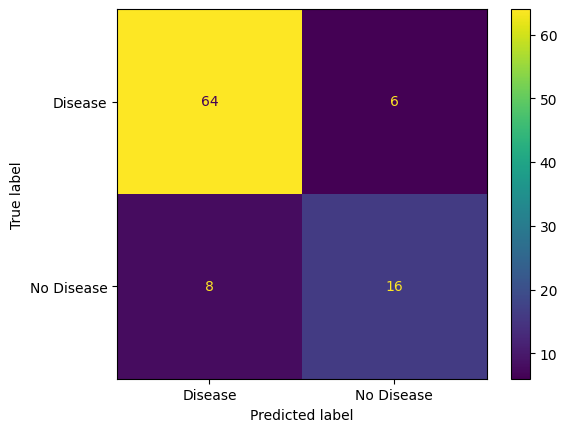

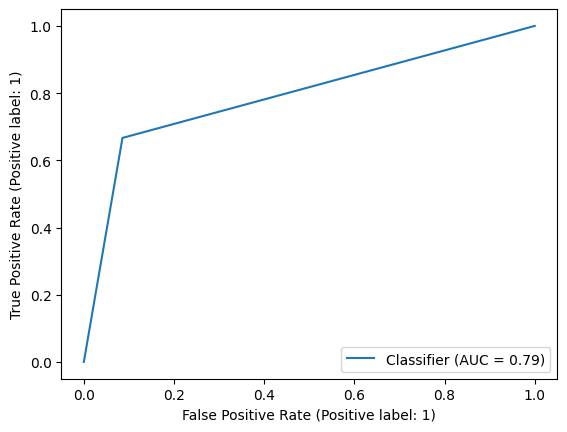

The Training Score is  1.0
The Test     Score is  0.86
Accuracy     Score is  0.89
Precision    Score is  0.72
Recall       Score is  0.41
best               is  {}


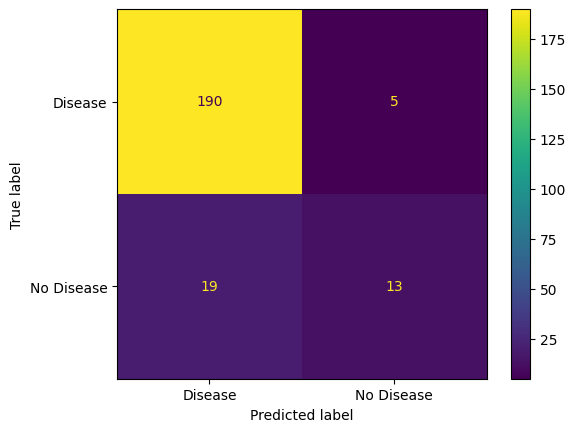

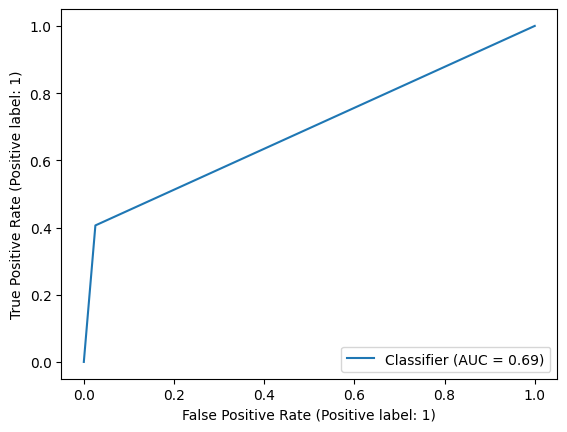

The Training Score is  0.78
The Test     Score is  0.76
Accuracy     Score is  0.81
Precision    Score is  0.71
Recall       Score is  0.42
best               is  {'RandomForest__max_depth': 5, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 500}


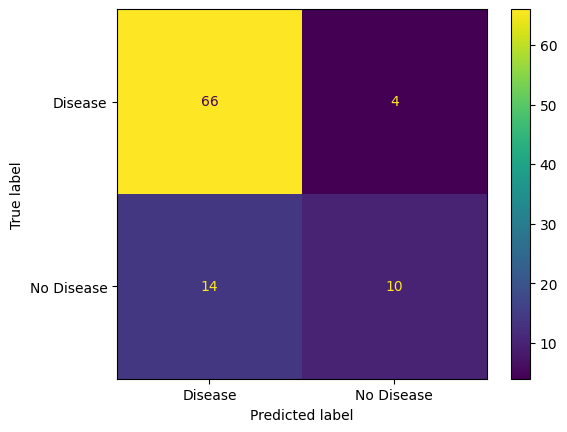

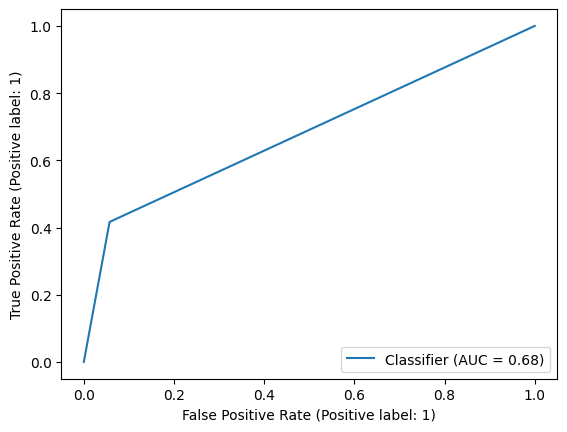

The Training Score is  0.83
The Test     Score is  0.82
Accuracy     Score is  0.88
Precision    Score is  1.0
Recall       Score is  0.12
best               is  {'RandomForest__max_depth': 10, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 750}


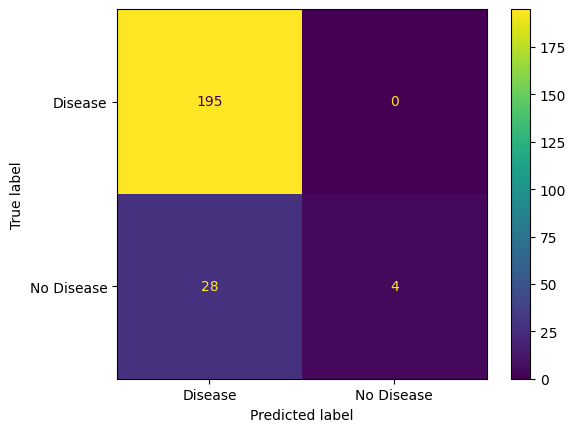

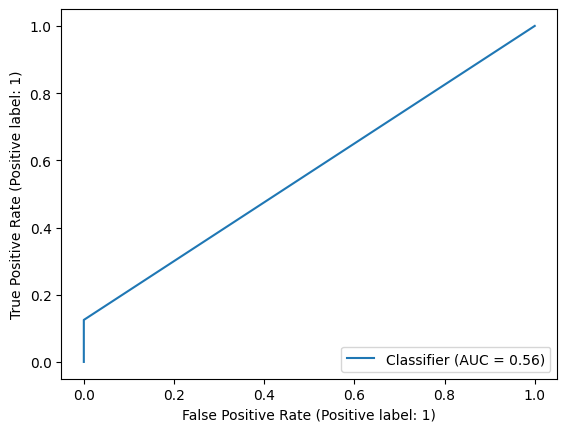

In [441]:
for index in range(0,len(experiments)):
    results(grid_male_list[index],  "RandomForest", XTest_male, yTest_male, prediction_male_list[index], model_3_forest_male, "h_model_3_forest_male")
    results(grid_female_list[index], "RandomForest", XTest_female, yTest_female, prediction_female_list[index], model_3_forest_female, "h_model_3_forest_female")

The Training Score is  1.0
The Test     Score is  0.84
Accuracy     Score is  0.85
Precision    Score is  0.73
Recall       Score is  0.67
best               is  {}


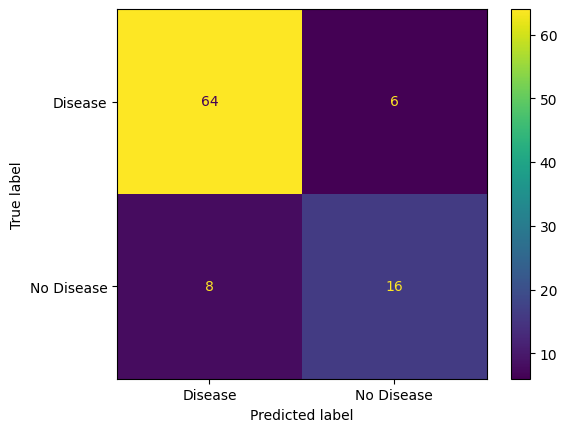

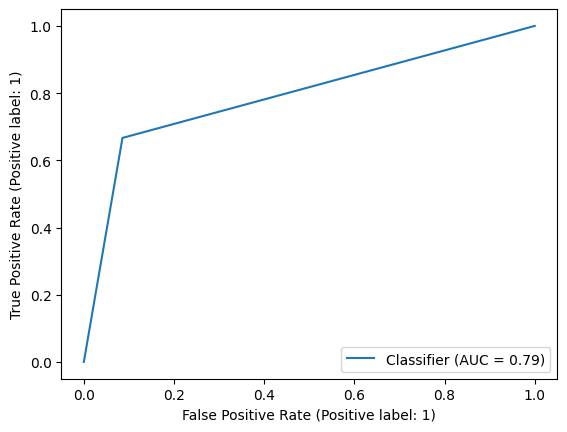

The Training Score is  1.0
The Test     Score is  0.86
Accuracy     Score is  0.89
Precision    Score is  0.72
Recall       Score is  0.41
best               is  {}


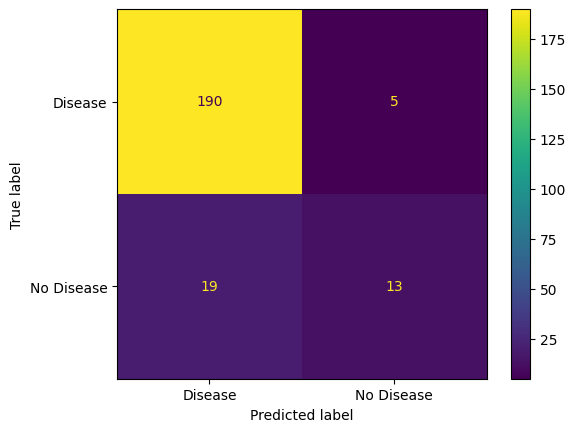

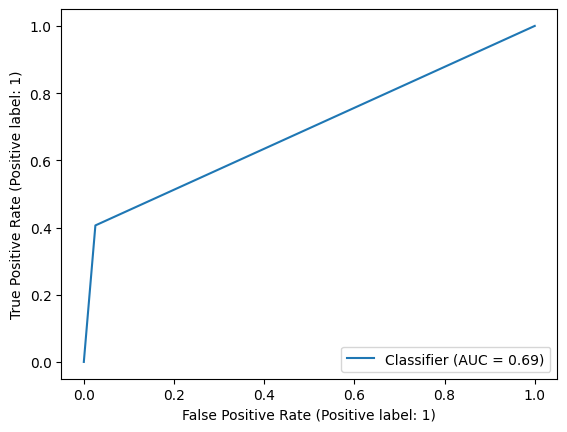

The Training Score is  0.78
The Test     Score is  0.76
Accuracy     Score is  0.81
Precision    Score is  0.71
Recall       Score is  0.42
best               is  {'RandomForest__max_depth': 5, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 500}


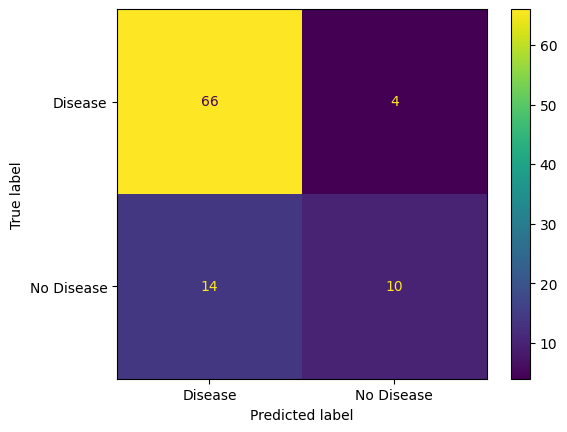

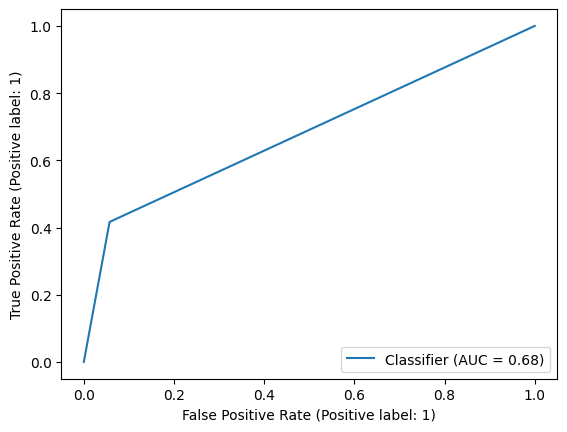

The Training Score is  0.83
The Test     Score is  0.82
Accuracy     Score is  0.88
Precision    Score is  1.0
Recall       Score is  0.12
best               is  {'RandomForest__max_depth': 10, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 750}


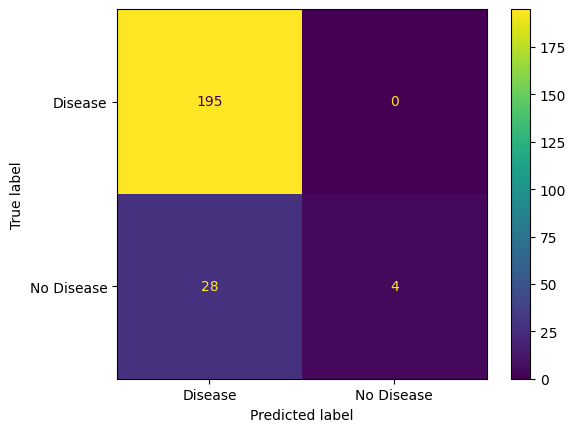

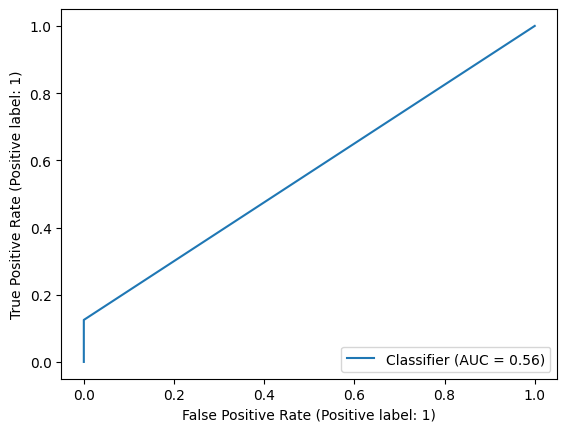

In [442]:
for index in range(0,len(experiments)):
    results(grid_male_list[index],  "RandomForest", XTest_male, yTest_male, prediction_male_list[index], model_3_forest_male, "h_model_3_gradient_male")
    results(grid_female_list[index], "RandomForest", XTest_female, yTest_female, prediction_female_list[index], model_3_forest_female, "h_model_3_gradient_female")

In [443]:
print("Historical results for male")
getDataFrame("h_model_3_forest_male")

Historical results for male


,Best Parameters,Training Score,Testing Score,Accuracy,Precision,Recall
0,{},1.00,0.84,0.85,0.73,0.67
1,"{'RandomForest__max_depth': 5, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 500}",0.78,0.76,0.81,0.71,0.42


In [444]:
print("Historical results for male")
getDataFrame("h_model_3_forest_female")

Historical results for male


,Best Parameters,Training Score,Testing Score,Accuracy,Precision,Recall
0,{},1.00,0.86,0.89,0.72,0.41
1,"{'RandomForest__max_depth': 10, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 750}",0.83,0.82,0.88,1.00,0.12


In [445]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {}
parameters_1 = {
    'min_samples_split': [2,3],
    'min_samples': [25, 50, 75],
    'max_depth': [5,8],
    'max_features': ["sqrt","log2", 15 ]
}

# Make the PipeLine 
pipeline = Pipeline(
    [
        ( "Column Transformers", columnTransformer),
        ( "Gradient ", GradientBoostingClassifier())
    ])

grid_males = []
grid_females = []
y_prediction_males = []
y_prediction_females = [] 

experiments = [ parameters, parameters_1 ]
for experiment in experiments: 
    (grid, y_predictions_male) = trainTestScore(pipeline, parameters, 10, (XTrain_male, yTrain_male), (XTest_male, yTest_male))
    (grid2, y_predictions_female) = trainTestScore(pipeline, parameters, 10, (XTrain_female, yTrain_female), (XTest_female, yTest_female))
    grid_males.append(grid)
    grid_females.append(grid2)
    y_prediction_females.append(y_prediction_females)
    y_prediction_males.append(y_prediction_males) 

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=1.000, test=0.821) total time=   0.1s
[CV 2/10] END .............., score=(train=1.000, test=0.821) total time=   0.1s
[CV 3/10] END .............., score=(train=1.000, test=0.821) total time=   0.1s
[CV 4/10] END .............., score=(train=1.000, test=0.893) total time=   0.1s
[CV 5/10] END .............., score=(train=1.000, test=0.786) total time=   0.0s
[CV 6/10] END .............., score=(train=1.000, test=0.857) total time=   0.0s
[CV 7/10] END .............., score=(train=1.000, test=0.821) total time=   0.0s
[CV 8/10] END .............., score=(train=1.000, test=0.964) total time=   0.0s
[CV 9/10] END .............., score=(train=1.000, test=0.857) total time=   0.0s
[CV 10/10] END ............., score=(train=1.000, test=0.889) total time=   0.0s
(94, 12)
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=0.985, test=0.85

Feature Engineering
Analysis of Males
model =  <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Analysis of Females
model =  <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


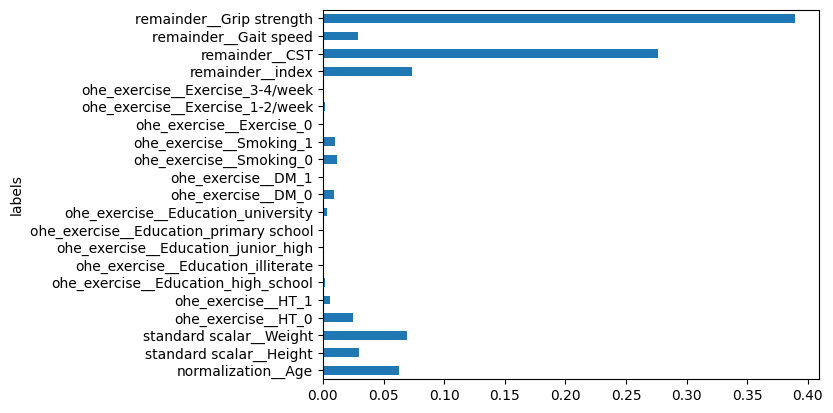

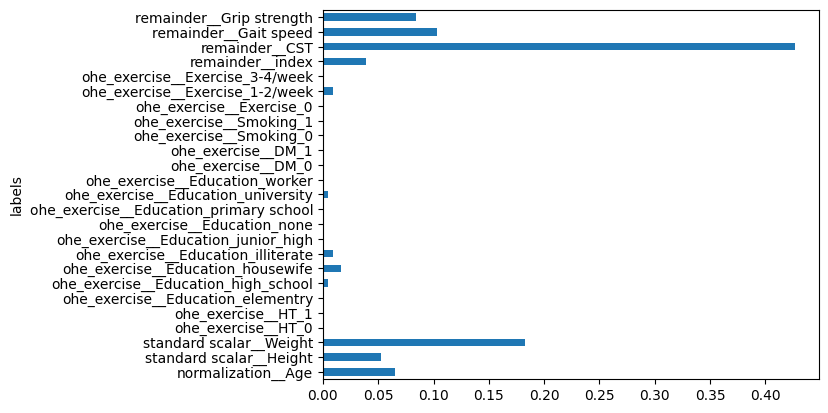

In [446]:
print("Feature Engineering")

print("Analysis of Males")
feature_random_forest(grid)

print("Analysis of Females")    
feature_random_forest(grid2)

In [447]:
print("Historical results for male")
getDataFrame("h_model_3_gradient_male")

Historical results for male


,Best Parameters,Training Score,Testing Score,Accuracy,Precision,Recall
0,{},1.00,0.84,0.85,0.73,0.67
1,"{'RandomForest__max_depth': 5, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 500}",0.78,0.76,0.81,0.71,0.42
2,{},1.00,0.84,0.85,0.73,0.67
3,"{'RandomForest__max_depth': 5, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 500}",0.78,0.76,0.81,0.71,0.42


In [448]:
print("Historical results for female")
getDataFrame("h_model_3_gradient_female")

Historical results for female


,Best Parameters,Training Score,Testing Score,Accuracy,Precision,Recall
0,{},1.00,0.86,0.89,0.72,0.41
1,"{'RandomForest__max_depth': 10, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 750}",0.83,0.82,0.88,1.00,0.12
2,{},1.00,0.86,0.89,0.72,0.41
3,"{'RandomForest__max_depth': 10, 'RandomForest__max_features': 18, 'RandomForest__max_samples': 15, 'RandomForest__n_estimators': 750}",0.83,0.82,0.88,1.00,0.12
